# Práctica de reconstrucción.  Parte II. Visión estéreo

Visión Computacional <br>
Practica 2.

**Alumnos:**
- César García Cabeza
- Enol García Gonzalez

Este enunciado está en el archivo "PracticaStereo.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* reconstruir puntos de una escena a partir de una serie de correspondencias manuales entre dos imágenes calibradas;
* determinar la geometría epipolar de un par de cámaras a partir de sus matrices de proyección;
* implementar la búsqueda automática de correspondencias que use las restricciones impuestas por la geometría epipolar, aplicando para ello métodos de cortes de grafos;
* realizar una reconstrucción densa de la escena.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV
* La librería PyMaxFlow

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica`` del tema de visión estéreo. Esta
carpeta contiene:
* Una serie de pares estéreo en el directorio images;
el sufijo del fichero indica si corresponde a la cámara
izquierda (_left) o a la derecha (_right). Bajo el
directorio ``rectif`` se encuentran varios pares estéreo
rectificados.
* Un conjunto de funciones auxiliares de ``Python`` en 
el módulo ``misc.py``. La descripción de las funciones
puede consultarse con el comando help o leyendo
su código fuente.
* El archivo ``cameras.npz`` con las matrices de proyección del par de cámaras con el que se tomaron todas las imágenes con prefijo minoru.

## Condiciones

* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Introducción

En los problemas de visión estéreo se supondrá la existencia de un par de cámaras calibradas cuyas matrices de proyección $\mathbf{P}_i$ vienen dadas
por $$\mathbf{P}_1 = \mathbf{K}_1\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_1 & \mathbf{t}_1\\ \mathbf{0}^T & 1
    \end{bmatrix},$$ $$\mathbf{P}_2 = \mathbf{K}_2\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_2 & \mathbf{t}_2\\ \mathbf{0}^T & 1
    \end{bmatrix}.$$
    
En esta práctica se usarán las matrices de proyección de
dos cámaras para determinar la posición tridimensional
de puntos de una escena. Esto es posible siempre que se
conozcan las proyecciones de cada punto en ambas cámaras. Desafortunadamente, esta información no suele estar
disponible y para obtenerla es preciso emplear el contenido
de las imágenes (sus píxeles) en un proceso de búsqueda
conocido como puesta en correspondencia. Conocer las matrices de proyección de las cámaras permite acotar el área
de búsqueda gracias a las restricciones que proporciona la
geometría epipolar.

In [2]:
# uncomment to show results in a window
%matplotlib tk
import numpy as np
import scipy.ndimage as scnd
import matplotlib.pyplot as ppl
import maxflow.fastmin
import cv2
import misc
#Import library
from IPython.display import Image

## 1. Reconstrucción

Teniendo un conjunto de correspondencias entre dos
imágenes, con matrices de calibración $P_i$ conocidas, es
posible llevar a cabo una reconstrucción tridimensional de
dichos puntos. En el fichero ``cameras.npz`` se encuentran
las matrices de proyección para las dos cámaras. Para cargar
este fichero:

In [11]:
# CUIDADO
# Cargamos las dos matrices de proyección
with np.load("cameras.npz") as cameras:
    P1 = cameras["left"]
    print(P1)
    P2 = cameras["right"]
    print(P2)

[[-1.59319023e+02  4.10068927e+02 -8.61429776e+01  5.96021124e+04]
 [ 9.56736123e+01 -6.85256589e+00 -4.31511155e+02  2.98592912e+04]
 [-8.69896273e-01 -7.51069223e-02 -4.87482742e-01  5.44164509e+02]]
[[-1.49296958e+02  4.20482251e+02 -8.03699899e+01  2.66669558e+04]
 [ 9.61686671e+01 -2.92284678e+00 -4.41950717e+02  3.12991880e+04]
 [-8.64354364e-01 -5.83462724e-02 -4.99486983e-01  5.42414607e+02]]


**EXPLICACIÓN**
Tuvimos muchos problemas con la celda de arriba, cargando a veces las matrices de proyección y otras veces se quedaba colgado y no funcionaba.
Optamos por guardar las matrices de proyección en los dos numpy arrays de abajo una vez que la celda de arriba nos funcionó, para así evitarnos problemas.

In [ ]:
P1 = np.array([[-1.59319023e02,  4.10068927e02, -8.61429776e01,  5.96021124e04],
 [ 9.56736123e01, -6.85256589e00, -4.31511155e02,  2.98592912e04],
 [-8.69896273e-01, -7.51069223e-02, -4.87482742e-01,  5.44164509e02]])
P2 = np.array([[-1.49296958e02,  4.20482251e02, -8.03699899e01,  2.66669558e04],
 [ 9.61686671e01, -2.92284678e00, -4.41950717e02,  3.12991880e04],
 [-8.64354364e-01, -5.83462724e-02, -4.99486983e-01,  5.42414607e02]])

Todas las imágenes con el prefijo minoru comparten este par de matrices de proyección.

Leemos las imágenes y marcamos al menos seis puntos correspondientes en cada una de ella.

In [12]:
# Leemos las dos imágenes
img1 = cv2.imread("images/minoru_cube3_left.jpg")
img2 = cv2.imread("images/minoru_cube3_right.jpg")

In [13]:
# Pedimos al ususario por puntos correspondientes en ambas imágenes
pt1, pt2 = misc.askpoints(img1,img2)

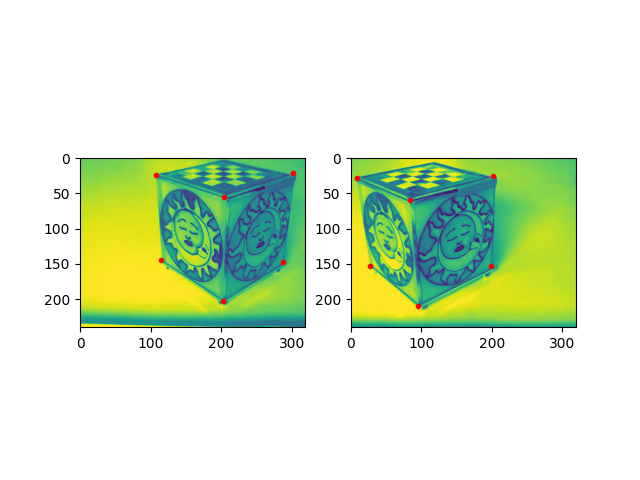

In [7]:
# Load image from local storage
Image(filename = "img/askPoints.png", width = 600, height = 600)

**Ejercicio 1.** Implementa la función ``M = reconstruct(points1, points2, P1, P2)``
que, dados una serie de N puntos 2D ``points1`` de la primera imagen y sus 
N homólogos ``points2`` de la segunda imagen
(ambos en coordenadas homogéneas, 3 x N), y el par de matrices
de proyección P1 y P2 de la primera y la segunda cámara
respectivamente, calcule la reconstrucción tridimensional
de cada punto. De ese modo, si ``points1`` y
``points2`` son 3 × N , la matriz resultante M debe ser 4 × N.

El tipo de reconstrucción debe ser algebraico, no geométrico.


Para resolver este ejercicio algebraicamente, debemos construir el siguiente sistema:

$
a_{11}X + a_{12}Y + a_{13}Z = - a_{14}\\
a_{21}X + a_{22}Y + a_{23}Z = - a_{24}\\
a'_{11}X + a'_{12}Y + a'_{13}Z = - a'_{14}\\
a'_{21}X + a'_{22}Y + a'_{23}Z = - a'_{24}
$

Las 4 ecuaciones de arriba corresponen al mismo punto, pero en dos escenas diferentes (dos ecuaciones primeras imagen 1 y las otras dos a la imagen 2).

La parte izquierda del igual, es lo que abajo construímos como A y la parte derecha como b.

Para calcular cada a, utilizaremos la sustitución vista en clase con la matriz de proyección.

In [14]:
# Función que dada las matrices de proyección y un mismo punto en dos imágenes devuelve el punto en la escena en coordeandas homogéneas
def triangular_punto(P1, P2, pt1, pt2):
    A = np.zeros(shape=(4,3))
    b = np.zeros(shape=(4,1))
    # Creamos la matriz A
    # Puntos de la imagen I
    for i in range(2):
        for j in range(3):
            A[i][j] = P1[i][j] - P1[2][j] * (pt1[0] if i == 0 else pt1[1])#np.power(new_pt1[0][0], i % 2) * np.power(new_pt1[0][1], (i + 1) % 2)
    # Puntos de la imagen I'
    for i in range(2):
        for j in range(3):
            A[i+2][j] = P2[i][j] - P2[2][j] * (pt2[0] if i == 0 else pt2[1])#np.power(new_pt2[0][0], i % 2) * np.power(new_pt2[0][1], (i + 1) % 2)
    # Creamos el vector b
    # Para la imagen I
    for i in range(2):
        j = 3
        b[i][0] = - (P1[i][j] - P1[2][j] * (pt1[0] if i == 0 else pt1[1]) )#np.power(new_pt1[0][0], i % 2) * np.power(new_pt1[0][1], (i + 1) % 2))
    # Para la imagen I'
    for i in range(2):
        j = 3
        b[i+2][0] = - (P2[i][j] - P2[2][j] * (pt2[0] if i == 0 else pt2[1]) )#np.power(new_pt2[0][0], i % 2) * np.power(new_pt2[0][1], (i + 1) % 2))

    # Resolvemos el sistema
    x, residuals, rank, s = np.linalg.lstsq(A,b)
    
    return np.append(x, 1)

In [18]:
def reconstruct(points1, points2, P1, P2):
    """Reconstruct a set of points projected on two images."""
    # Convertimos a coordenadas cartesianas
    new_pt1 =  [[points1[0][i], points1[1][i]]/ points1[2][i] for i in range(len(points1[0]))] 
    new_pt2 =  [[points2[0][i], points2[1][i]]/ points2[2][i] for i in range(len(points2[0]))]
    
    ret = np.zeros(shape=(4, len(points1[0])))
    # Hallamos el punto en la escena para cada punto en la imagen
    for i in range(len(new_pt1)):
        ret[:,i] = triangular_punto(P1, P2, new_pt1[i], new_pt2[i])
    return ret

Para comprobar que la función está biem implementada, se recalculan los puntos de la imágen utilizando P1 y P2 a partir de los de la escena calculados y se comparan con los marcados previamente. Podemos ver como hay pequeñas diferencias, que puede ser debido a un error mínimo introducido al calcular manualmente las correspondencias.

In [19]:
points3d = reconstruct(pt1, pt2, P1, P2)

for i in range(len(points3d[0])):
    x = points3d[:, i].reshape((4,1))
    # Recalculamos los puntos en las imágenes
    calculated_pt1 = np.dot(P1, x)
    calculated_pt2 = np.dot(P2, x)
    for j in range(len(calculated_pt1)):
        calculated_pt1[j][0] /= calculated_pt1[2][0]
        calculated_pt2[j][0] /= calculated_pt2[2][0]

    # Mostramos el punto recalculado en ambas escenas junto al original marcado
    print(f"calculated pt1: {calculated_pt1.reshape(1,3)}")
    print(f"pt1 real: {pt1[:,i]}")
    print(f"calculated pt2: {calculated_pt2.reshape(1,3)}")
    print(f"pt2 real: {pt2[:, i]}")

calculated pt1: [[202.47795391 203.27997702   1.        ]]
pt1 real: [202.46774194 202.67419355   1.        ]
calculated pt2: [[ 96.65229622 209.17799899   1.        ]]
pt2 real: [ 96.66129032 209.77096774   1.        ]
calculated pt1: [[208.20900857  58.05649933   1.        ]]
pt1 real: [208.14516129  56.48064516   1.        ]
calculated pt2: [[85.2551956  62.03564047  1.        ]]
pt2 real: [85.30645161 63.57741935  1.        ]
calculated pt1: [[300.42455744  25.3637806    1.        ]]
pt1 real: [300.40322581  26.67419355   1.        ]
calculated pt2: [[205.91952208  29.37120638   1.        ]]
pt2 real: [205.9516129   28.09354839   1.        ]
calculated pt1: [[289.05461812 149.48871368   1.        ]]
pt1 real: [289.0483871  150.15806452   1.        ]
calculated pt2: [[197.42690725 155.06915043   1.        ]]
pt2 real: [197.43548387 154.41612903   1.        ]
calculated pt1: [[116.08121637 145.63300139   1.        ]]
pt1 real: [115.88709677 143.06129032   1.        ]
calculated pt2: 

Reconstruye los puntos marcados y pinta su estructura 3D.

In [20]:
# reconstruct
mM=reconstruct(pt1, pt2, P1, P2)

# convert from homog to cartesian
mM = mM[0:3,:] / mM[3,:]
# plot 3D
misc.plot3D(mM[0,:],mM[1,:],mM[2,:])

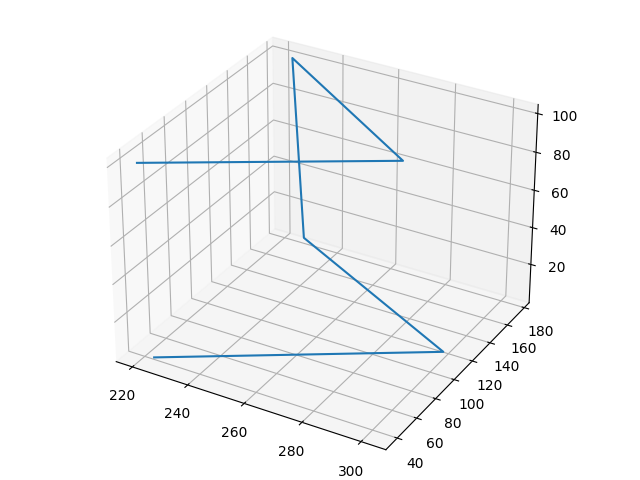

In [8]:
Image(filename = "img/reconstruction.png", width = 600, height = 600)

**Ejercicio 2.**  Elige un par estéreo de las imágenes del conjunto "building" de la práctica de calibración y realiza una reconstrucción de un conjunto de puntos de dicho edificio estableciendo las correspondencias a mano.

In [24]:
# Parámetros de la práctica anterior
vp1 = np.array([5739.80417367, 2581.55471629,1])
vp2 = np.array([4855.66315511, 2645.68868765,1])

K = np.array([[3.07135761e03, 0.00000000e00, 1.98914933e03],
 [0.00000000e00, 3.07135761e03, 1.46301851e03],
 [0.00000000e00, 0.00000000e00, 1.00000000e00]])

R1 = np.array([[-0.65754675,  0.75388299, -0.0093219 ],
 [ 0.27879649,  0.22482619, -0.93711472],
 [ 0.69993199,  0.617344, 0.34889699]])

R2 = np.array([[-0.75398465,  0.65677964, -0.01215072],
 [ 0.25101616,  0.27097504, -0.92928113],
 [ 0.60704039,  0.70371374,  0.36917332]]) 


# Calculamos T
#T1 =
#T2 = 

#extrinsics1 = np.zeros((3,4))
#extrinsics1[:,:3] = R1
#extrinsics1[:,3] = T1

#extrinsics2 = np.zeros((3,4))
#extrinsics2[:,:3] = R2
#extrinsics2[:,3] = T2

#bP1 = np.dot(K,extrinsics1)
#bP2 = np.dot(K, extrinsics2)

#b1 = cv2.imread("images/building/build_001.jpg")
#b2 = cv2.imread("images/building/build_003.jpg")

#bpt1, bpt2 = misc.askpoints(b1,b2)
# reconstruct
#mM=reconstruct(bpt1, bpt2, bP1, bP2)

# convert from homog to cartesian
#mM = mM[0:3,:] / mM[3,:]
# plot 3D
#misc.plot3D(mM[0,:],mM[1,:],mM[2,:])

**Ejercicio 3.**  Reproyecta los resultados de la reconstrucción
en las dos cámaras y dibuja las proyecciones sobre las
imágenes originales. Pinta también en otro color los puntos seleccionados manualmente. Comprueba si las proyecciones coinciden con los puntos marcados a mano. Comenta los resultados.
Para dibujar los puntos puedes usar la función plothom
de la práctica anterior o la versión que se distribuye con esta
práctica (misc.plothom).

Al no hacer el ejercicio 2, utilizamos los resultados del ejercicio 1 para poder hacer este ejercicio.

In [25]:
# Proyecto los puntos en ambas cámaras
proy1 = P1.dot(points3d)
proy2 = P2.dot(points3d)

# Pinto con misc.plothom()
ppl.figure()
misc.plothom(pt1,'bx')
misc.plothom(proy1,'r.')
ppl.imshow(img1)
ppl.show()

ppl.figure()
misc.plothom(pt2,'bx')
misc.plothom(proy2,'r.')
ppl.imshow(img2)
ppl.show()

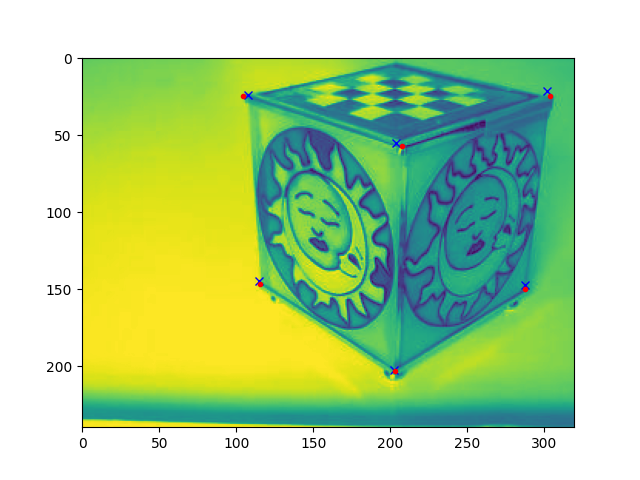

In [9]:
Image(filename = "img/reprojection1.png", width = 600, height = 600)

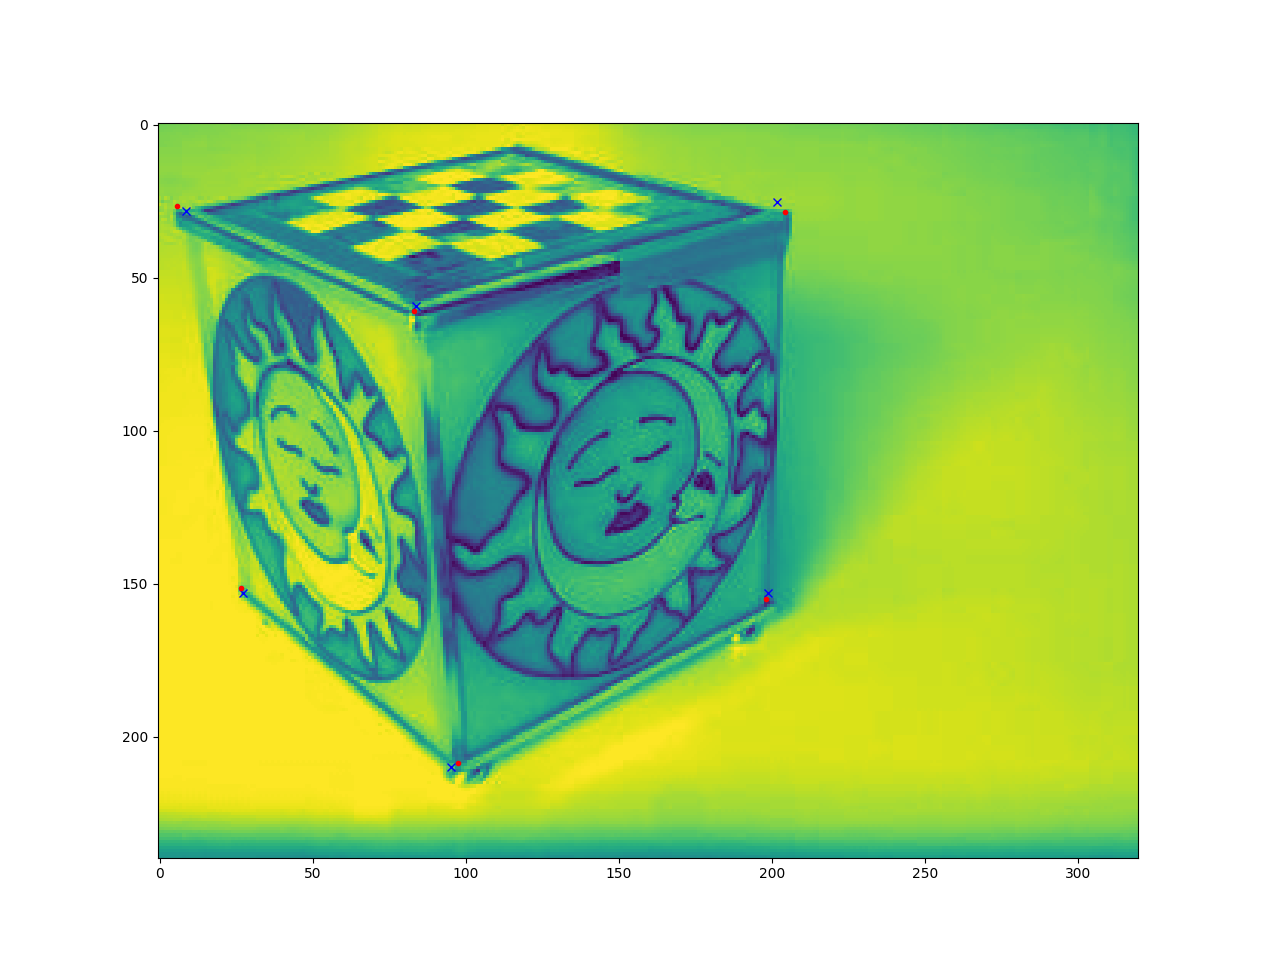

In [10]:
Image(filename = "img/reprojection2.png", width = 600, height = 600)

## 2. Geometría epipolar

La geometría epipolar deriva de las relaciones que aparecen en las proyecciones de una escena sobre un par de
cámaras. La matriz fundamental $\mathbf{F}$, que depende exclusivamente de la configuración de las cámaras y no de la escena
que éstas observan, es la representación algebráica de dicha
geometría: a partir de ella se pueden calcular los epipolos
y las líneas epipolares. La relación entre un par de cámaras
$\mathbf{P}_1$, $\mathbf{P}_2$ y la matriz fundamental es de n -a- 1 (salvo factor de
escala). Es decir, dadas dos cámaras calibradas, sólo tienen
una matriz fundamental (excepto un factor de escala); dada
una matriz fundamental existen infinitas configuraciones de
cámaras posibles asociadas a ella.

### 2.1 Estimación de la matriz fundamental

**Ejercicio 4.** Implementa la función ``F = projmat2f(P1, P2)``
que, dadas dos matrices de proyección, calcule la matriz
fundamental asociada a las mismas. $\mathbf{F}$ debe ser tal que,
si $m_1$ de la imagen 1 y $m_2$ de la imagen 2 están en
correspondencia, entonces $m_2^\top F m_1 = 0$.

La matriz fundamental F viene dada por la siguiente fórmula:

$
B^{-T}[B^{-1}d-A^{-1}b]_{x}A^{-1}m
$

Pudiendo obtener A y b de la matriz de proyección de la cámara 1 y B y d de la matriz de proyección de la cámara 2.

$
P_{1} = [A|b]\\
P_{2} = [B|d]
$

In [11]:
def projmat2f(P1,P2): 
    """ Calcula la matriz fundamental a partir de dos de proyeccion"""
    # Descomponemos las matrices de proyección en A,B, b y d
    A = P1[:, 0:3]
    B = P2[:, 0:3]
    b = P1[:, 3]
    d = P2[:, 3]

    A_ = np.linalg.inv(A)
    B_ = np.linalg.inv(B)

    B_aux = np.dot(B_,d)
    A_aux = np.dot(A_,b)
    aux = B_aux - A_aux
    # Convertimos aux con la transformación vista en clase
    aux = np.array([[0, -aux[2], aux[1]], [aux[2], 0, -aux[0]], [-aux[1], aux[0], 0]])
    F = np.dot(np.dot(B_.T, aux), A_)
    
    return F

In [12]:
# compute Fundamental matrix
F = projmat2f(P1, P2)
# Comprobamos la mtriz
print(F)

[[ 8.37919568e-09 -2.64352512e-06  8.61308150e-04]
 [ 8.17120624e-06  4.36740646e-06  1.37641118e-01]
 [-2.27541882e-03 -1.42176578e-01  7.61494803e-03]]


**Ejercicio 5** ¿Cómo es la matriz fundamental de dos cámaras
que comparten el mismo centro? (Por ejemplo, dos cámaras
que se diferencian sólo por una rotación.)

La matriz fundamental de dos camaras con el mismo centro es una matriz compuestas por todo ceros. Básandose en la fórmula:

$ F = [K't]_X K'RK^{-1}  $

Si la traslación es 0, el resultado de los productos es 0.

### 2.2 Comprobación de F (OPCIONAL)

En los siguientes dos ejercicios vamos a comprobar que la matriz F estimada a partir de P1 y P2 es correcta.

**Ejercicio 6.** Comprueba que F es la matriz fundamental asociada a las cámaras ``P1`` y ``P2``. Para ello puedes utilizar el resultado 9.12, que aparece en la página 255 del libro Hartley, Zisserman. "Multipe View Geometry in Computer Vision." (sedond edition). Cambridge University Press, 2003.

Como indican en el libro:
*A non-zero matrix F is the fundamental matrix corresponding to a pair of camera matrices P and P' if and only if P'_TFP is skew-symmetric.*

Si una matrix es antisimétrica, por definición:
A + A_T = 0

Entonces comprobaremos que se cumple esa propiedad.

In [13]:
# Seguimos el ejemplo del libro
producto = np.dot(np.dot(P2.T,F), P1)

# Si es la matrix fundamnetal, la suma del producto y su transpuesta debería ser 0
print(producto + producto.T)
# En este caso vemos que no sale 0 literal, pero puede ser por errores de cálculo de los tipos, aún así vemos que algunos son 0 y otros son valores muy muy pequeños cercanos a 0.

[[ 3.76871283e-15 -7.66053887e-15 -7.10542736e-15  1.81898940e-12]
 [-7.66053887e-15 -2.82567271e-17  3.24185123e-14 -1.87583282e-12]
 [-7.10542736e-15  3.24185123e-14 -1.28541701e-13  1.09139364e-11]
 [ 1.81898940e-12 -1.87583282e-12  1.09139364e-11 -3.82231373e-09]]


También se puede comprobar geométricamente la bondad de una matriz F, si  las epipolares con ella estimadas pasan por el homólogo de un punto dado en una de las imágenes.

Dada la matriz fundamental $\mathbf{F}$ entre las cámaras 1 y 2,
se puede determinar, para un determinado punto $m_1$ en la
imagen de la cámara 1, cuál es la recta epipolar $l_2$ donde se
encontrará su homólogo en la cámara 2: $$l_2 = \mathbf{F} m_1.$$

Las siguientes dos funciones sirven para comprobar esta
propiedad. En primer lugar, se necesita una función que
dibuje rectas expresadas en coordenadas homogéneas, es
decir, la versión de plothom para rectas en lugar de puntos.

**Ejercicio 7.** Implementa la función ``plothline(line)``
que, dada una línea expresada en coordenadas homogéneas,
la dibuje.

In [16]:
def plothline(line, axes = None):
    """Plot a line given its homogeneous coordinates.
    
    Parameters
    ----------
    line : array_like
        Homogeneous coordinates of the line. // ax + by + c = 0
    axes : AxesSubplot
        Axes where the line should be plotted. If not given,
        line will be plotted in the active axis.
    """
    if axes == None:
        axes = ppl.gca()

    #print(line)
    
    [x0, x1, y0, y1] = axes.axis()

    #     (x0, y0) ._____________________. (x1, y0)
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #     (x0, y1) .---------------------. (x1, y1)
 
    # Compute the intersection of the line with the image
    # borders.
    # Representamos las rectas de los bordes en coordenada homogéneas
    coordenadas_izq = (1, 0, -x0)
    coordenadas_der = (1, 0, -x1)
    coordenadas_sup = (0, 1, -y0)
    coordenadas_inf = (0, 1, -y1)

    # Calculamos la intersección de la línea con cada borde utilizando el producto
    corte_izq = [line[1]*coordenadas_izq[2] - coordenadas_izq[1]*line[2], coordenadas_izq[0]*line[2] - line[0]*coordenadas_izq[2], line[0]*coordenadas_izq[1] - coordenadas_izq[0]*line[1]]
    corte_izq /= corte_izq[2]
    corte_der = [line[1]*coordenadas_der[2] - coordenadas_der[1]*line[2], coordenadas_der[0]*line[2] - line[0]*coordenadas_der[2], line[0]*coordenadas_der[1] - coordenadas_der[0]*line[1]]
    corte_der /= corte_der[2]
    corte_sup = [line[1]*coordenadas_sup[2] - coordenadas_sup[1]*line[2], coordenadas_sup[0]*line[2] - line[0]*coordenadas_sup[2], line[0]*coordenadas_sup[1] - coordenadas_sup[0]*line[1]]
    corte_sup /= corte_sup[2]
    corte_inf = [line[1]*coordenadas_inf[2] - coordenadas_inf[1]*line[2], coordenadas_inf[0]*line[2] - line[0]*coordenadas_inf[2], line[0]*coordenadas_inf[1] - coordenadas_inf[0]*line[1]]
    corte_inf /= corte_inf[2]

    xs = []
    ys = []

    # Comprobamos en qué borde corta y lo añadimos al acumulador de arriba
    if y1 <= corte_izq[1] <= y0:
        xs += [x0]
        ys += [corte_izq[1]]
    if y1 <= corte_der[1] <= y0:
        xs += [x1]
        ys += [corte_der[1]]
    if x0 <= corte_sup[0] <= x1:
        y0 += [y0]
        x0 += [corte_sup[0]]
    if x0 <= corte_inf[0] <= x1:
        y0 += [y1]
        x0 += [corte_inf[0]]

    # print(xs)
    # print(ys)
    # Plot the line with axes.plot.
    #axes.plot(xs, ys)
    plotline = axes.plot(xs, ys, 'r-')
    
    axes.axis([x0, x1, y0, y1])
    return plotline

**Ejercicio 8.** Completa la función ``plot_epipolar_lines(image1, image2, F)``
que, dadas dos imágenes y la matriz fundamental que
las relaciona, pide al usuario puntos en la imagen 1 y
dibuje sus correspondientes epipolares en la imagen 2 usando ``plothline``.

In [17]:
def plot_epipolar_lines(image1, image2, F):
    """Ask for points in one image and draw the epipolar lines for those points.
    
    Parameters
    ----------
    image1 : array_like
        First image.
    image2 : array_like
        Second image.
    F : array_like
        3x3 fundamental matrix from image1 to image2.
    """
    # Prepare the two images.
    fig = ppl.gcf()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image1)
    ax1.axis('image')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(image2)
    ax2.axis('image')
    ppl.draw()
    
    ax1.set_xlabel("Choose points in left image (or right click to end)")
    point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    while len(point) != 0:
        # point has the coordinates of the selected point in the first image.
        point = np.hstack([np.array(point[0]), 1])
        ax1.plot(point[0], point[1], '.r')
        
        # Determine the epipolar line.
        # Por definición la linea epipolar es la multiplicación de F por el punto
        line = np.dot(F, point)
        
        # Plot the epipolar line with plothline (the parameter 'axes' should be ax2).
        plothline(line, axes=ax2)
        
        ppl.draw()
        # Ask for a new point.
        point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    
    ax1.set_xlabel('')
    ppl.draw()

Utiliza esta función con un par de imágenes llamándola
de dos formas diferentes: seleccionando puntos en la imagen
izquierda y dibujando las epipolares en la imagen derecha
y viceversa. Comprueba en ambos casos que las epipolares
siempre pasan por el punto de la segunda imagen correspondiente al seleccionado en la primera. Esto confirmara la corrección de la matriz F.

Añade dos figuras una que muestre la selección de puntos en
la imagen izquierda y las rectas correspondientes en la
imagen derecha, y otra que lo haga al revés. Indica para
ambos casos qué matriz fundamental has usado al llamar a
``plot_epipolar_lines``.

In [43]:
# Para representar las rectas de puntos de la imagen 1 en la imagen 2 usamos la matriz F.
plot_epipolar_lines(img1, img2, F)

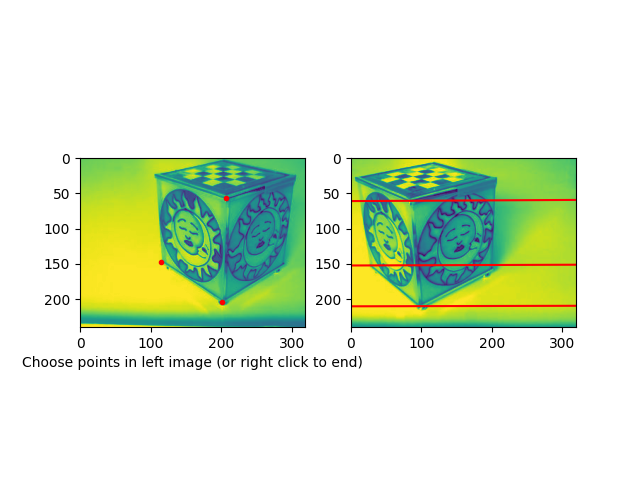

In [11]:
Image(filename = "img/epipolars1.png", width = 600, height = 600)

In [44]:
# Para representar las rectas de puntos de la imagen 2 en la imagen 1 usamos la matriz rtanspuesa de F.
plot_epipolar_lines(img2, img1, np.transpose(F))

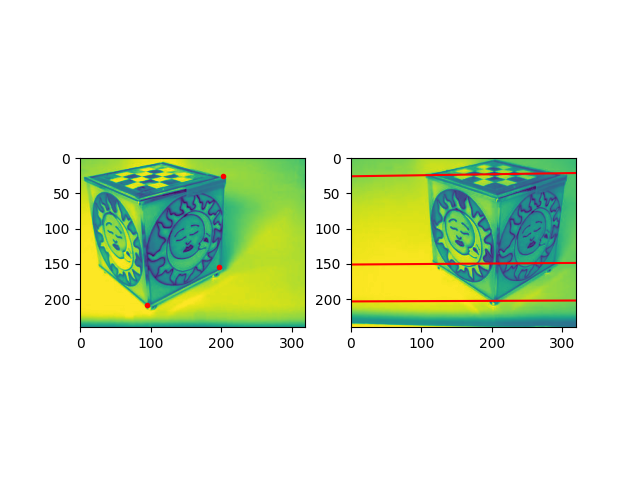

In [12]:
Image(filename = "img/epipolars2.png", width = 600, height = 600)

##  3. Rectificación de imágenes

Es recomendable trabajar a partir de ahora con imágenes
en blanco y negro y con valores reales entre 0 y 1 para cada
uno de sus píxeles. Eso se puede conseguir con

In [20]:
img1 = misc.rgb2gray(img1/255.0)
img2 = misc.rgb2gray(img2/255.0)

La mayoría de algoritmos de puesta en correspondencia,
incluyendo el que se va a implementar en esta práctica,
requieren que las imágenes de entrada estén rectificadas.

Dos imágenes están rectificadas si sus correspondientes epipolares están alineadas horizontalmente. La rectificación de
imágenes facilita enormemente los algoritmos de puesta en
correspondencia, que pasan de ser problemas de búsqueda
bidimensional a problemas de búsqueda unidimensional
sobre filas de píxeles de las imágenes. En el material de
la práctica se han incluido dos funciones que rectifican
(mediante un método lineal) dos imágenes. La función
``H1, H2 = misc.projmat2rectify(P1, P2, imsize)``
devuelve, dadas las dos matrices de proyección y el tamaño de las imágenes en formato (filas,columnas), las
homografías que rectifican, respectivamente, la imagen 1
y la imagen 2. La función ``projmat2rectify`` hace uso
de ``projmat2f``, por lo que
es necesario que esta función esté disponible.

**Ejercicio 9.** Se tienen dos imágenes no rectificadas ``im1`` e
``im2``, y su matriz fundamental asociada $\mathbf{F}$ . Con el procedimiento explicado, se encuentran un par de homografías $\mathbf{H}_1$ y $\mathbf{H}_2$ que dan lugar a las imágenes rectificadas ``O1`` y ``O2``. ¿Cuál es la matriz fundamental $\mathbf{F}′$ asociada a estas dos imágenes? ¿Por qué?

Nota: F ′ depende exclusivamente de F , H1 y H2.

La matriz fundamental F' es:

$ F' = H^{-T}_2 F H^{-1}_1 $

Esta relación entre ambas matrices fundamentales está extraída de la página 253 del libro de Hartley y Zisserman.

**Ejercicio 10.** Rectifica el par de imágenes estéreo ``img1`` e ``img2`` y calcula
la matriz fundamental asociada a estas imágenes.

In [21]:
# Homografías
H1, H2 = misc.projmat2rectify(P1, P2, projmat2f, img1.shape)
# Imágens rectificadas
O1, O2 = misc.rectify_images(img1, img2, H1, H2)

In [45]:
# Mostramos las imágenes rectificadas
ppl.figure()
ppl.imshow(O1)
ppl.figure()
ppl.imshow(O2)

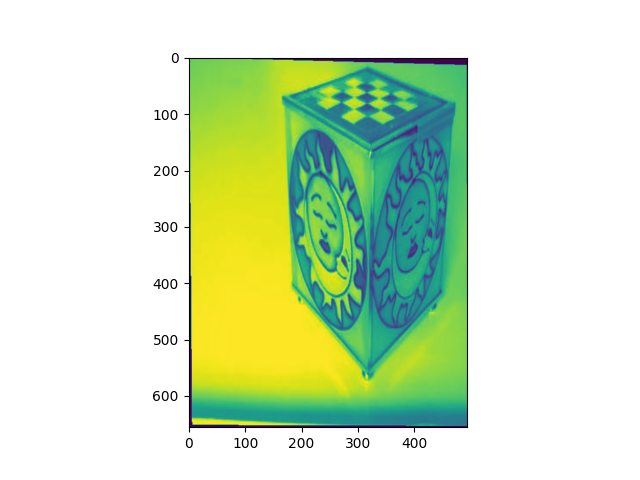

In [13]:
Image(filename = "img/rectified1.png", width = 600, height = 600)

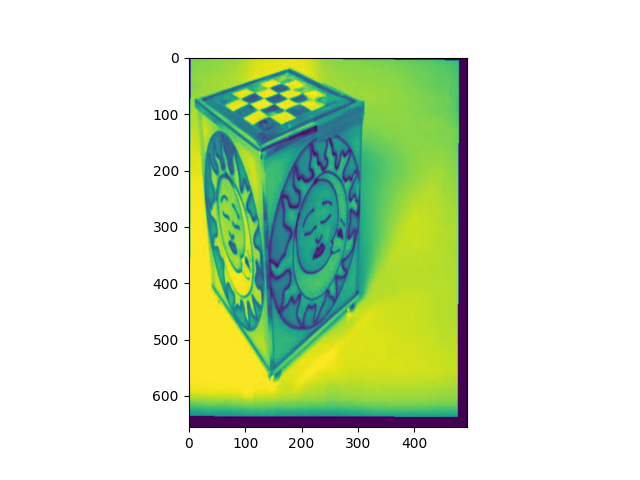

In [14]:
Image(filename = "img/rectified2.png", width = 600, height = 600)

**Ejercicio 11.** Calcula y muestra la matriz fundamental de las imágenes
rectificadas. Justifica el resultado obtenido (mira la sección 9.3.1 del libro de Hartley y Zisserman, pág. 248 y 249).

Aplicamos la fórmula del ejercicio 9 y comprobamos que la matriz tiene la forma siguiente:

0 0 0

0 0 -1

0 1 0

In [23]:
Fr=np.dot(np.dot(np.linalg.inv(H2.transpose()), F), np.linalg.inv(H1))
Fr=Fr/Fr[2,1]
Fr

array([[ 4.17470918e-22, -4.15104069e-17,  5.22305036e-15],
       [ 4.57185342e-17,  7.20057323e-18, -1.00000000e+00],
       [-5.37014259e-15,  1.00000000e+00,  6.14597487e-13]])

**Ejercicio 12.** Usa ``plot_epipolar_lines`` para dibujar varias líneas epiplares de las imágenes rectificadas. Muestra los resultados.

In [46]:
# Utilizamos la matriz
plot_epipolar_lines(O1, O2, Fr)

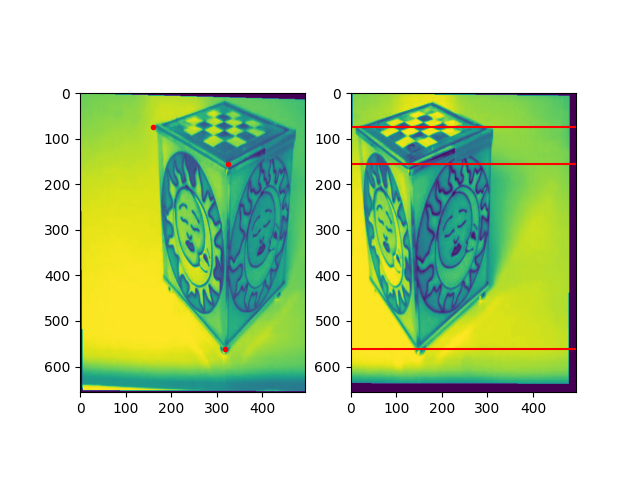

In [15]:
Image(filename = "img/epipolarsRectified.png", width = 600, height = 600)

## 4. Búsqueda de correspondencias

La búsqueda de correspondencias consigue establecer automáticamente las correspondencias de puntos entre dos
imágenes (lo que se ha hecho manualmente en el ejercicio 2)
haciendo uso de las restricciones que proporciona la geometría epipolar.

### 4.1 Cálculo de las medidas de similaridad

Una vez rectificadas las dos imágenes de un par estéreo,
se pueden buscar las correspondencias. Una matriz de disparidades $\mathbf{S}$ indica, para cada píxel de la imagen 1
rectificada, a cuántos píxeles de diferencia está su correspondencia
en la imagen 2 rectificada. En nuestra práctica, para simplificar el problema, vamos a considerar que los elementos
de $\mathbf{S}$ son enteros. Para el píxel en la posición $(x, y)$ en la
imagen 1, su correspondiente está en $(x + S[y, x], y)$ en la
imagen 2. Si $S[y, x] < 0$, la correspondencia está hacia la
izquierda; si $S[y, x] > 0$, la correspondencia está hacia la
derecha; si $S[y, x] = 0$, las coordenadas de los dos puntos
coinciden en ambas imágenes.

La búsqueda de correspondencias requiere ser capaz de
determinar el parecido visual entre píxeles de dos imágenes.
Si los píxeles $m_1$ y $m_2$ son visualmente parecidos, tienen
más probabilidad de estar en correspondencia que otros
que sean visualmente diferentes. Como la
apariencia (el nivel de gris) de un único píxel es propensa
al ruido y poco discriminativa, el elemento de puesta en
correspondencia será una ventana centrada en el píxel.
Dado un píxel $m$ de una imagen, llamaremos vecindad
del píxel de radio $K$ al conjunto de píxeles de la imagen que se encuentren dentro de una ventana de tamaño
$(2K + 1) × (2K + 1)$ píxeles centrada en $m$ . El número de
píxeles de una vecindad de radio $K$ es $N = (2K + 1)^2$.
Dadas dos vecindades $w_1$ y $w_2$ de dos píxeles, el parecido
visual entre ellas puede calcularse con la suma de *diferencias
al cuadrado (SSD)* de cada una de sus componentes
$$d_{SSD}(\mathbf{v}, \mathbf{w}) = \sum_{i=1}^N(\mathbf{v}_i - \mathbf{w}_i)^2.$$

La distancia $d_{SSD}$ es siempre positiva, es pequeña cuando
dos ventanas son visualmente parecidas y grande en caso
contrario.

**Ejercicio 13.** Implementa la función
``C = localssd(im1, im2, K)``
que calcula la suma de diferencias al cuadrado entre las
ventanas de radio K de la imagen 1 y la imagen 2. El
resultado debe ser una matriz del mismo tamaño que las
imágenes de entrada que contenga en cada punto el valor
de $d_{SSD}$ para la ventana de la imagen 1 y la ventana
de la imagen 2 centradas en él. Es decir, $C[i,j]$ debe
ser el resultado de $d_{SSD}$ para las ventanas centradas en
$im1[i,j]$ e $im2[i,j]$.

Para este ejercicio puede resultar útil la función
``scipy.ndimage.convolve``.

In [26]:
def localssd(im1, im2, K):
    """
    The local sum of squared differences between windows of two images.
    
    The size of each window is (2K+1)x(2K+1).
    """
    conv = np.ones(shape=(2*K+1, 2*K+1))
    diff = np.power(im2 - im1, 2)

    return scnd.convolve(diff, conv)

In [47]:
# Calculamos la suma de diferencias al cuadrado
ret = localssd(O1, O2, 5)

# Ploteamos
ppl.figure()
ppl.imshow(ret, cmap='gray')

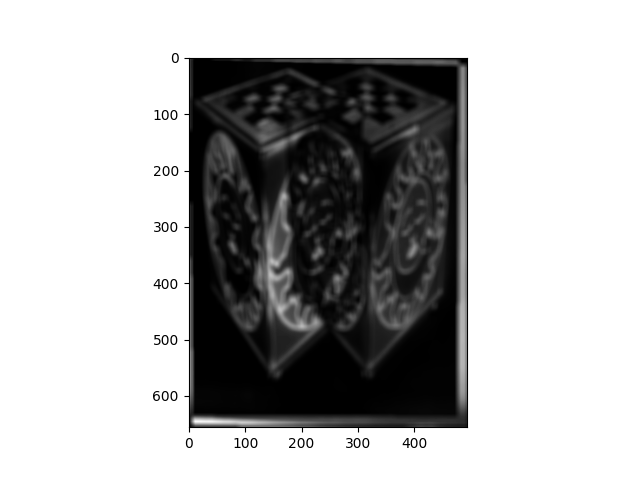

In [3]:
Image(filename = "img/localssd.png", width = 600, height = 600)

**Ejercicio 14.** Implementa la función ``D = ssd_volume(im1, im2, disps, K)`` que calcula la suma de diferencias al cuadrado entre las
ventanas de la imagen ``im1`` y la imagen ``im2`` desplazada
horizontalmente. El parámetro ``disps`` debe ser una lista
de valores indicando las disparidades que se usarán para desplazar la imagen ``im2``. Por ejemplo, si ``disps`` es
``np.arange(-3,2)``, se llamará 5 veces a ``localssd`` para la
imagen 1 y la imagen 2 desplazada −3 , −2 , −1 , 0 y 1 píxeles
en sentido horizontal. K es el parámetro que indica el radio
de las ventanas usado por localssd.

El valor devuelto D será un array de tamaño $M × N × L$,
donde L es el número de disparidades indicadas por ``disps``,
``L = len(disps)`` (es decir, el número de veces que se ha
llamado a ``localssd``); M y N son, respectivamente, el
número de filas y de columnas de las imágenes de entrada.
El elemento ``D[y,x,l]`` debe ser la SSD entre la ventana
centrada en ``im1[y,x]`` y la ventana centrada en ``im2[y,x + disps[l]]``.

``D[y,x,l]`` debe ser muy grande para aquellos valores en
los que ``im2[y,x + disps[l]]`` no esté definido, es decir,
el índice``(y,x+disps[l])`` se sale de la imagen 2.

In [4]:
def ssd_volume(im1, im2, disps, K):
    """
    Calcula el volumen de disparidades SSD
    """
    D = np.zeros(shape=(np.shape(im1)[0],np.shape(im1)[1],len(disps)))
    for d in range(len(disps)):
        img_desp = np.zeros(im2.shape)
        img_desp[:,:-disps[d]:] = im2[:,disps[d]:]
        D[:,:,d] = localssd(im1, img_desp, K)
        
    return D

**Ejercicio 15.** El conjunto de disparidades ``disps`` debe ser lo más pequeño posible, para mejorar el rendimiento de la optimización. Determina un procedimiento para estimar manualmente el conjunto de disparidades posibles y aplícalo a las imágenes O1 y O2.

Para derterminar que conjunto de disparidades se iba a emplear se mostraron las dos imágenes por pantalla y de forma aproximada se apuntó la posición X de un punto en la imágen 1 y la posición X' de un punto en la imágen 2. Al analizar la diferencia entre los valores de X y X' se observó como había una diferencia entorno a 170-180 píxeles por lo que este conjunto de disparidades debe de contener al menos estos valores obtenidos de las diferencias. Como se trata de un proceso manual y no muy preciso, se añadio un margen superior e inferior de 20 pixeles más, por lo que el conjunto de disparidades irá desde 150 (20 pixeles menos que 170) hasta 200 (20 pixeles por encima de 180).

In [5]:
disps = np.arange(150, 200)

Aplica la función ``ssd_volume`` al par de imágenes O1 y O2
con las disparidades estimadas en el ejercicio anterior.

In [48]:
D = ssd_volume(O2, O1, disps, 5)

# to speed-up the optimization ahead, discard the par of the image showing only background

# Mostramos la correspondiente a 14, es decir, 164 de desplazamiento
ppl.figure()
ppl.imshow(D[:,:,14], cmap='gray')

#ppl.figure()
#ppl.imshow(D[:,200,:], cmap='gray')

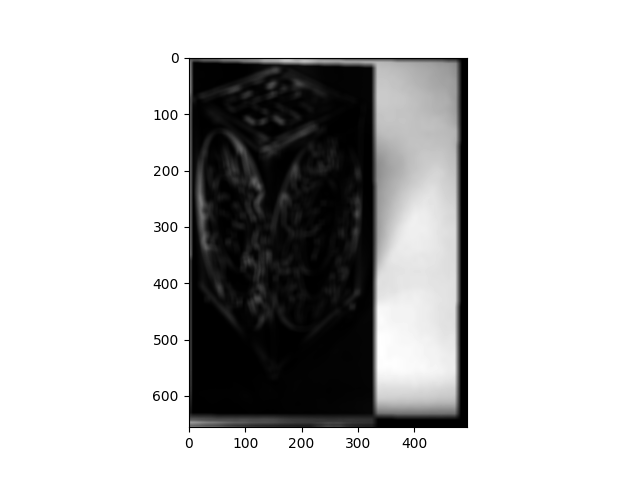

In [2]:
Image(filename = "img/ssd_volume14.png", width = 600, height = 600)

### 4.1 Estimación de la disparidad sin regularizar

La matriz D calculada en el ejercicio anterior proporciona
los costes unitarios $D_i$ de una función de energía sin regularización de la forma $$E(x) = \sum_{i} D_i(x_i),$$
donde $D_i(l)$ viene dado por $D[y,x,l]$, suponiendo que
el píxel $i$ tenga coordenadas $(x, y)$. Las variables 
$x = (x_1 ,\ldots, x_{NM})$ indican las etiquetas de cada uno de los
píxeles. En este caso, las etiquetas son los índices del
array ``disps``, que a su vez son las disparidades horizontales.
Por eso, a partir de aquí se hablará indistintamente de
etiquetas y disparidades. Sólo es necesario recordar que la
etiqueta $l$ está asociada a la disparidad ``disps[l]``.


Minimizando la energía $x = \arg\min_x E(x)$,
se obtiene un vector de etiquetas óptimo $x^*$ que indica, para
cada píxel, cuál es su disparidad horizontal entre las dos
imágenes.

**Ejercicio 16.** Minimiza $E(x)$ y muestra las disparidades resultantes.

In [49]:
# El valor mínimo se puede obtener directamente con argmin
res = D.argmin(axis=2)
ppl.figure()
ppl.imshow(res,cmap='gray')
ppl.colorbar()

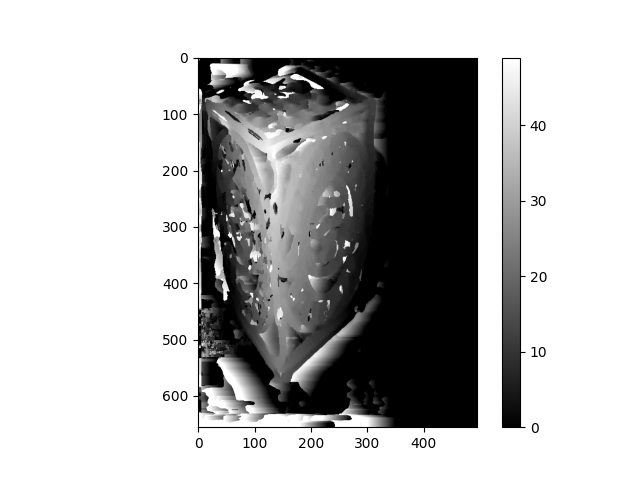

In [3]:
Image(filename = "img/minE.png", width = 600, height = 600)

### 4.2 Estimación de la disparidad regularizada

El etiquetado usando exclusivamente términos unitarios
es muy sensible al ruido y propenso a que aparezcan zonas
de píxeles cercanos con mucha variación en las etiquetas.
Esto es especialmente notable en zonas planas (es decir, sin
textura) de las imágenes originales, donde no hay suficiente
información para establecer una correspondencia basándose
exclusivamente en la apariencia visual de ventanas pequeñas. Por eso es necesario incluir un término de suavizado
o regularización en la función de energía. Los tipos de
saltos de etiquetas que aparecerán en el resultado final
dependerán de cómo sea ese término de suavizado.

La función de energía que utilizaremos para calcular
las disparidades en la práctica será el resultado de añadir
a la expresión (6) un término que penalice los cambios de
disparidad en los píxeles vecinos: $$E_r(x) = \sum_{i} D_i(x_i) + \lambda\sum_{ij} \min(k,|x_i-x_j|).$$ Siendo $j$ los índices de los píxeles vecinos del $i$ en la imagen.
La solución al problema de la correspondencia vendrá dado
por el conjunto de etiquetas (disparidades) de los píxeles de
la imagen que minimicen $E_r(x)$.

En [Yuri Boykov, Olga Veksler, and Ramin Zabih. "Fast approximate
energy minimization via graph cuts". *IEEE Transactions on Pattern
Analysis and Machine Intelligence*, 23:1222–1239, 2001.] se presentan métodos para resolver algunos problemas de optimización con varias etiquetas empleando
algoritmos de cortes de grafos. Es recomendable repasar las
secciones 5 y 8.

**Ejercicio 17.** Escribe la función ``find_corresp_aexpansion(D, initLabels, lmb, maxV)``,
que recibe un volumen ssd, ``D``, un conjunto inicial de
etiquetas, ``initLabels``, que puede ser el obtenido en el
ejercicio 5, el valor de la constante $\lambda$, y el valor máximo
de la función de coste $|x_i − x_j|$, que tendrás que establecer empíricamente. El resultado de esta función serán las
etiquetas que minimizan $E_r(x)$. Para ello debes utilizar la función ``maxflow.fastmin.aexpansion_grid(D, V, max_cycles=None, labels=None)`` del paquete
*PyMaxFlow*, que resuelve el problema anterior mediante un
algoritmo de cortes de grafos empleando una $\alpha$-expansión.

In [33]:
def find_corresp_aexpansion(D, initialLabels, lmb, maxV):
    return maxflow.fastmin.aexpansion_grid(D, lmb*maxV, max_cycles=None, labels=initialLabels)

Llama a esta función y muestra una figura con las etiquetas que resulten de la minimización de la energía para el volumen ssd ``D`` (este proceso puede durar varios minutos).

In [34]:
num_labels = D.shape[-1]
X,Y = np.mgrid[:len(disps), :len(disps)]
V = 2 * np.float_(np.abs(X-Y))
labels = find_corresp_aexpansion(D, res, .5, V)

In [50]:
ppl.figure()
ppl.imshow(labels)

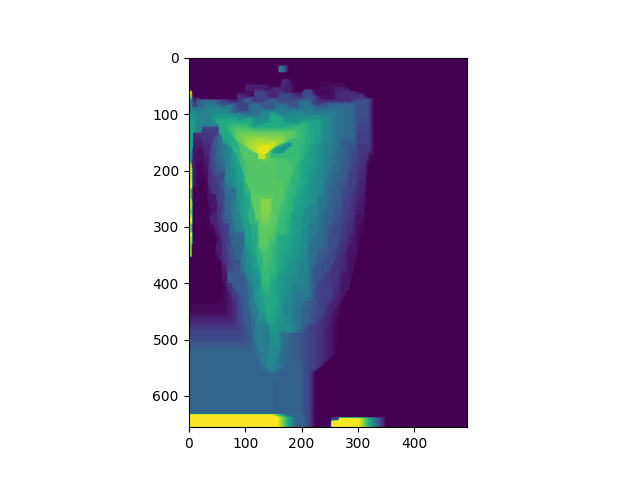

In [4]:
Image(filename = "img/labels.png", width = 600, height = 600)

El algoritmo aexpansión utilizado utiliza un etiquetado inicial, que en este caso es el que se obtuvo del ejercicio 16 al minimizar la función de energía y una matriz V para la energía smooth. En este caso esta matriz V se calculo mediante el producto de un valor lambda y una matriz de diferencias. El valor de lambda se estimó empiricamente mediante diferentes pruebas y observando cual era el mejor valor obtenido. La matriz de diferencias se calculo haciendo la diferencia de dos matrices, X e Y. X es una matriz en la que cada fila contiene el índice de un valor de disparidad y todos los valores de esa fila son idénticos. Y es matriz similar a la anterior pero en este caso todos los valores de una misma columna son ideénticos y representan una posición de disparidades. Para entender este concepto mejor, si hubiese 3 disparidades (que son las obtenidas empiricamente en el ejercicio 15), las matrices serían
$$
X = 
\begin{matrix}
     0 & 0 & 0\\
     1 & 1 & 1\\
     2 & 2 & 2
\end{matrix},
Y = 
\begin{matrix}
     0 & 1 & 2\\
     0 & 1 & 2\\
     0 & 1 & 2
\end{matrix}
$$

Ésta definción de la matriz V se obtuvo de la propia librería PyMaxFlow, ya que un resolvedor de esterográmas implementado en la librería define la matriz V tal y como la definimos nosotros.

La matriz de etiquetas óptimas X obtenida de la minimización de la función de energía puede transformarse en
la matriz de disparidades S indexando en cada una de sus
celdas el array de disparidades disps ``S = disps[X]``.
Ahora, el píxel de coordenadas (x, y) de la primera imagen
rectificada tendrá su correspondencia en el píxel de coordenadas (x + S [y, x], y) de la segunda imagen rectificada.

El siguiente ejercicio usa la matriz de disparidades para
establecer automáticamente las correspondencias entre un
par de imágenes sin rectificar.

**Ejercicio 18.** Implementa la función
``plot_correspondences(image1, image2, S, H1,H2)``
que, dado un par de imágenes sin rectificar, la matriz de
disparidades entre las imágenes rectificadas y las homogra-
fías que llevan de las imágenes sin rectificar a las imágenes
rectificadas, pida al usuario puntos en la primera imagen y
dibuje sus correspondencias en la segunda.

In [36]:
def plot_correspondences(image1, image2, S, H1, H2):
    """
    Ask for points in the first image and plot their correspondences in
    the second image.
    
    Parameters
    ----------
    image1, image2 : array_like
        The images (before rectification)
    S : array_like
        The matrix of disparities.
    H1, H2 : array_like
        The homographies which rectify both images.
    """
    # Prepare the two images.
    fig = ppl.gcf()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image1)
    ax1.axis('image')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(image2)
    ax2.axis('image')
    ppl.draw()
    
    ax1.set_xlabel("Choose points in left image (or right click to end)")
    point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    while len(point) != 0:
        # point has the coordinates of the selected point in the first image.
        point = np.c_[np.array(point), 1].T
        ax1.plot(point[0,:], point[1,:], '.r')
        
        # Determine the correspondence of 'point' in the second image.
        # perhaps you have to swap the image co-ordinates.
        punto1_rectificado = np.dot(H1, point)
        punto1_rectificado /= punto1_rectificado[2]
        punto2_rectificado = [punto1_rectificado[0] - S[int(punto1_rectificado[1]), int(punto1_rectificado[0])], punto1_rectificado[1], 1.]
        punto2 = np.dot(np.linalg.inv(H2), punto2_rectificado)
        punto2 /= punto2[2]
        
        
        # Plot the correspondence with ax2.plot.
        ax2.plot(punto2[0], punto2[1] ,'r.')
        
        ppl.draw()
        # Ask for a new point.
        point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    
    ax1.set_xlabel('')
    ppl.draw()

In [54]:
S = disps[labels]
plot_correspondences(img1, img2, S, H1, H2)

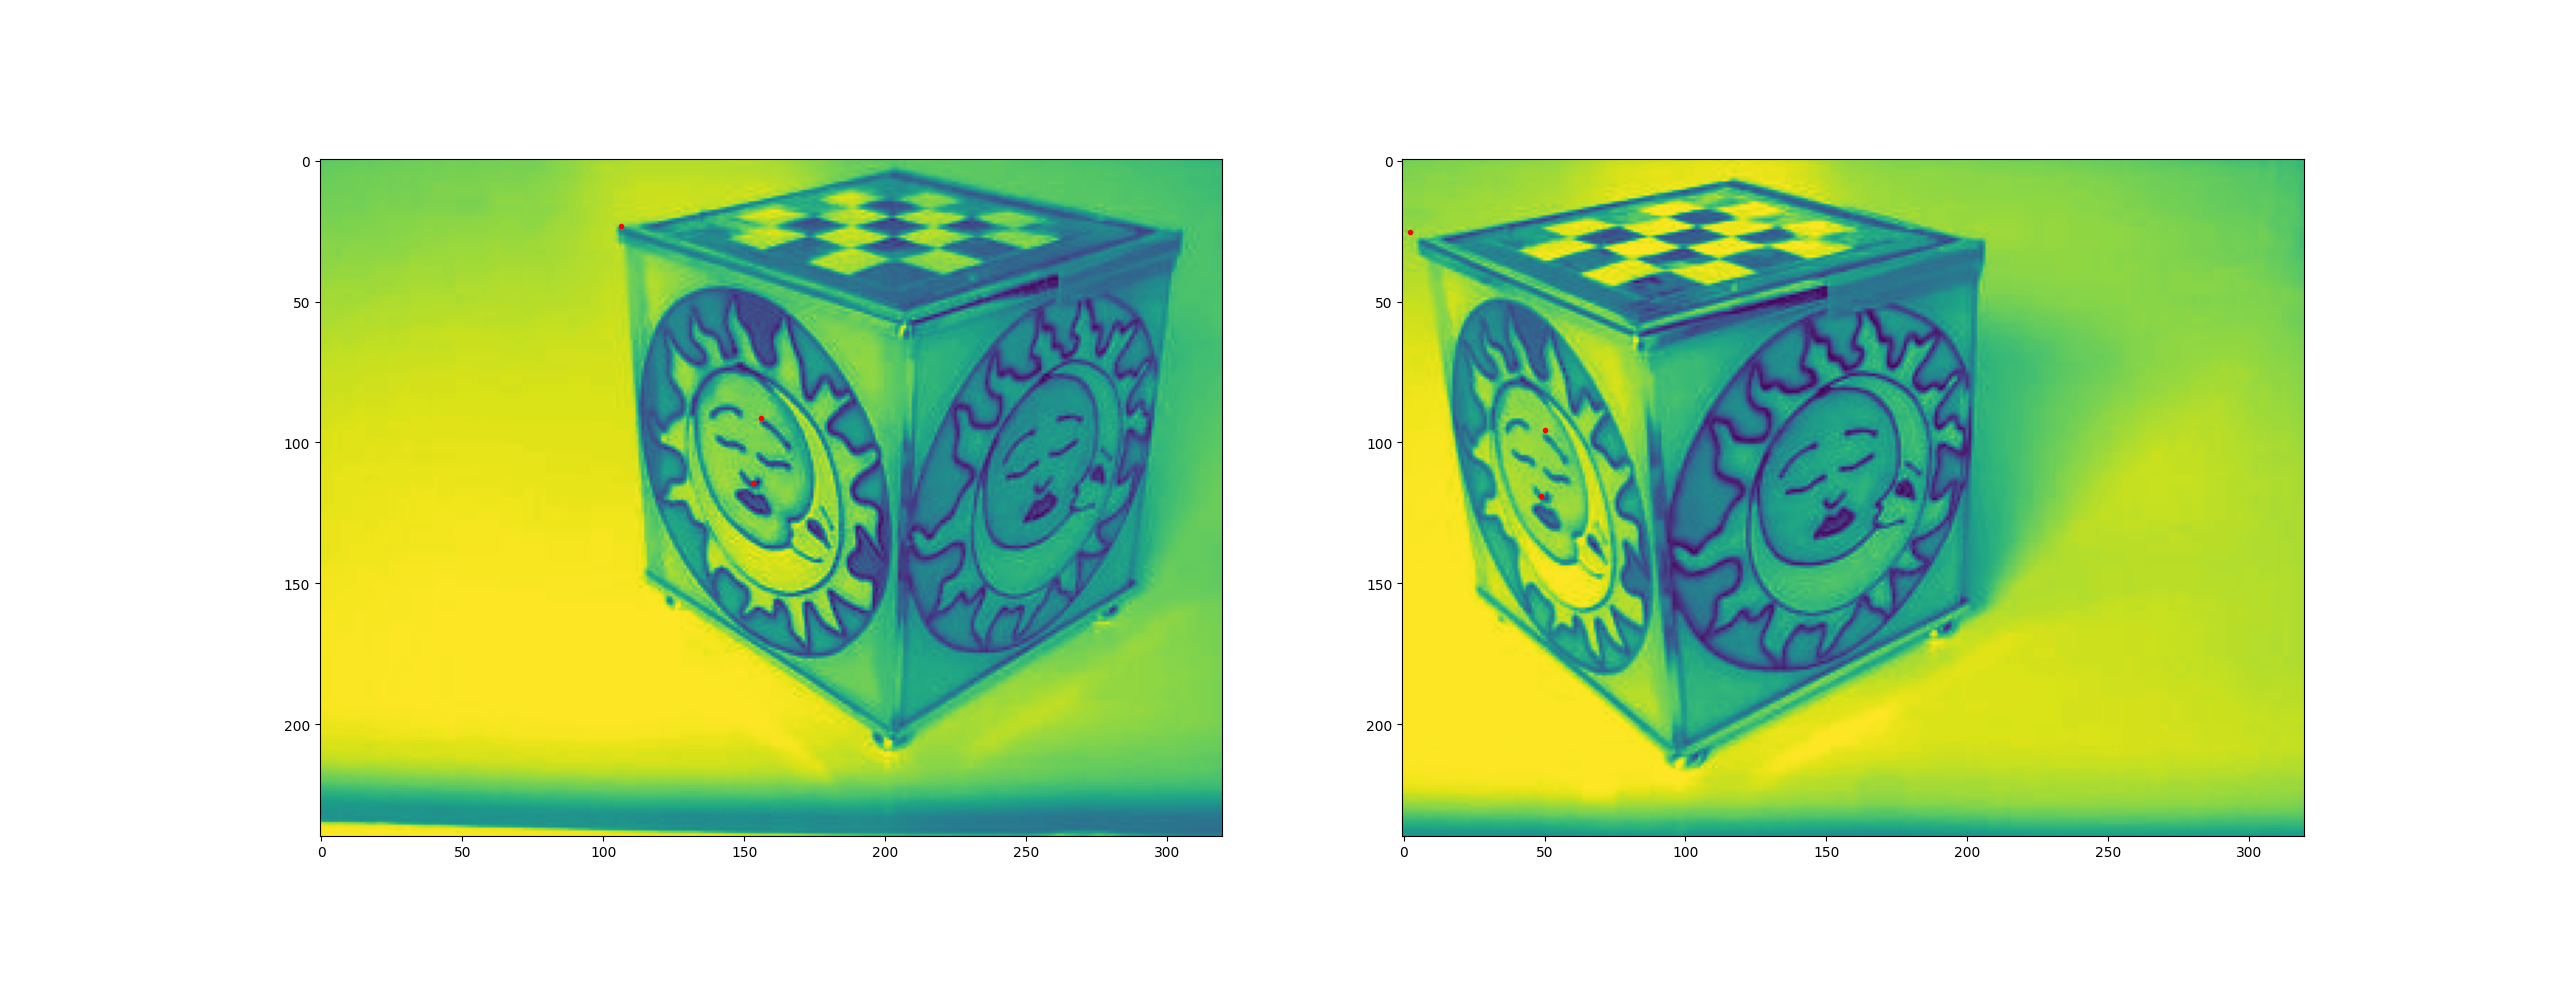

In [8]:
Image(filename = "img/correspondences.png", width = 2000, height = 2000)

Podemos comprobar como para puntos situados en la cara izquierda del cubo la búsqueda de correspondencias funciona bastante bien. Sin embargo, con las esquinas funciona bastante peor así como con la cara derecha del cubo.